## 2. Model Implementation


Running the data wrangling bit can be quite computationally intensive, and


In [1]:
%pip install optuna
%pip install tabulate
%pip install seaborn
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# load in the np data from the cleaneddata folder
final_doc_test = np.load("cleaneddata/final_doc_test.npy")
final_doc_train = np.load("cleaneddata/final_doc_train.npy")
final_qn_train = np.load("cleaneddata/final_qn_train.npy")
final_qn_test = np.load("cleaneddata/final_qn_test.npy")
tr_labels = np.load("cleaneddata/tr_labels.npy")
ts_labels = np.load("cleaneddata/ts_labels.npy")

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# check the shape of all the above
print(
    final_doc_test.shape,
    final_doc_train.shape,
    final_qn_train.shape,
    final_qn_test.shape,
    tr_labels.shape,
    ts_labels.shape,
)

(630, 200, 156) (2117, 200, 156) (2117, 23, 156) (630, 23, 156) (2117, 200) (630, 200)


In [5]:
# convert the numpy arrays to tensors
final_doc_test = torch.from_numpy(final_doc_test).to(device=device, dtype=torch.float32)
final_doc_train = torch.from_numpy(final_doc_train).to(
    device=device, dtype=torch.float32
)
final_qn_train = torch.from_numpy(final_qn_train).to(device=device, dtype=torch.float32)
final_qn_test = torch.from_numpy(final_qn_test).to(device=device, dtype=torch.float32)

In [6]:
# check the shapes of the tensors
print(
    final_doc_test.shape,
    final_doc_train.shape,
    final_qn_train.shape,
    final_qn_test.shape,
)

torch.Size([630, 200, 156]) torch.Size([2117, 200, 156]) torch.Size([2117, 23, 156]) torch.Size([630, 23, 156])


**Input Embedding Ablation Study**

In the model input embedding Ablation study, we are given 3 variations of input embeddings to test. We will test 3 options:

1. Word2Vec only # 100 dims
2. Word2Vec + Tf-IDF # 101 dims
3. Word2Vec + all features (TF-IDF, POS, NER) # 156 dims

Since we are using tensors, we can use tensor slicing to take out the relevant features.
Our tensor of embeddings are built as follows (w2v, TF-IDF, POS, NER)


In [7]:
def convert_tensors(tf_doc_train, tf_doc_test, tf_qn_train, tf_qn_test, option=3):
    if option == 3:
        return tf_doc_train, tf_doc_test, tf_qn_train, tf_qn_test
    elif option == 1:
        tf_doc_train = tf_doc_train[:, :, :100]
        tf_doc_test = tf_doc_test[:, :, :100]
        tf_qn_train = tf_qn_train[:, :, :100]
        tf_qn_test = tf_qn_test[:, :, :100]
        return tf_doc_train, tf_doc_test, tf_qn_train, tf_qn_test
    elif option == 2:
        tf_doc_train = tf_doc_train[:, :, :101]
        tf_doc_test = tf_doc_test[:, :, :101]
        tf_qn_train = tf_qn_train[:, :, :101]
        tf_qn_test = tf_qn_test[:, :, :101]
        return tf_doc_train, tf_doc_test, tf_qn_train, tf_qn_test

In [8]:
# Create a mapping from label to index
label2index = {"N": 0, "S": 1, "I": 2, "E": 3}

# Find the maximum length of the label lists
max_len = final_doc_train.shape[1]

# Create a tensor to hold the one-hot encoded labels
train_labels = torch.zeros(
    len(tr_labels), max_len, len(label2index), device=device, dtype=torch.float32
)
test_labels = torch.zeros(
    len(ts_labels),
    max_len,
    len(label2index),
    device=device,
    dtype=torch.float32,
)

# Sets the first element of the third dimension of the target_labels tensor to 1
train_labels[:, :, 0] = 1
test_labels[:, :, 0] = 1

# Iterate over the label lists and one-hot encode the labels
for i, label_list in enumerate(tr_labels):
    for j, label in enumerate(label_list):
        index = label2index[label]
        # Sets all elements of the target_labels tensor at position (i,j) to 0
        train_labels[i, j] = 0
        train_labels[i, j, index] = 1

for i, label_list in enumerate(ts_labels):
    for j, label in enumerate(label_list):
        index = label2index[label]
        # Sets all elements of the target_labels tensor at position (i,j) to 0
        test_labels[i, j] = 0
        test_labels[i, j, index] = 1

In [9]:
from sklearn.utils.class_weight import compute_class_weight

# Reshape the target labels tensor
reshaped_target_labels = (
    train_labels.view(-1, 4).cpu().numpy()
)  # Assuming it's on the GPU

# Flatten the reshaped target labels
flattened_target_labels = reshaped_target_labels.argmax(axis=1)

# Calculate the class weights
class_weights = compute_class_weight(
    class_weight="balanced", classes=[0, 1, 2, 3], y=flattened_target_labels
)

# Convert the class weights to a PyTorch tensor
class_weights = torch.tensor(class_weights, dtype=torch.float32, device=device)

Data Preprocessing complete at this stage, we should check again the shapes of the tensors


## 3. Model Architecture


In [10]:
from torch import Tensor
from enum import Enum
from typing import Literal

In [11]:
# Architecture of the model for the Document BiLSTM


class DocumentBiRNN(nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers=1,
    ):
        super(DocumentBiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers=num_layers,
            bidirectional=True,
        )

    def forward(self, input: Tensor):
        input = input.unsqueeze(1)
        output: Tensor
        output, _ = self.lstm(input)
        # print("document output shape: ", output.shape)
        return output


# Architecture of the model for the Question BiLSTM


class QuestionBiRNN(nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers=1,
    ):
        super(QuestionBiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers=num_layers,
            bidirectional=True,
        )

    def forward(self, input: Tensor):
        input = input.unsqueeze(1)
        output, (hn, cn) = self.lstm(input)
        forward_hn = hn[-2, :, :]
        backward_hn = hn[-1, :, :]
        hidden = torch.cat((forward_hn, backward_hn), dim=-1).unsqueeze(0)
        # print("question hidden shape: ", hidden.shape)
        return hidden


# attention methods
class AttentionMethod(Enum):
    DOT_PRODUCT = "dot_product"
    SCALE_DOT_PRODUCT = "scale_dot_product"
    COSINE_SIMILARITY = "cosine_similarity"

    def __str__(self):
        return self.value


# Architecture of the model for the Attention Calculation


class Attention(nn.Module):
    def __init__(
        self,
        ques_len,
        hidden_size: int,
        attention_method: Literal[
            "dot_product",
            "scale_dot_product",
            "cosine_similarity",
        ] = "dot_product",
    ):
        super(Attention, self).__init__()
        self.out = nn.Linear(ques_len, hidden_size)
        self.hidden_size = hidden_size
        self.attention_method = AttentionMethod(attention_method)

    def forward(self, document_output, question_summary):
        if self.attention_method == AttentionMethod.DOT_PRODUCT:
            document_output = document_output.permute(
                1, 0, 2
            )  # torch.Size([200, 1, 16])
            question_summary = question_summary.permute(
                1, 2, 0
            )  # torch.Size([1, 16, 1])

            attention_scores = torch.bmm(document_output, question_summary).permute(
                1, 0, 2
            )
            # get attention weights
            attention_weights = nn.functional.softmax(attention_scores, dim=1)
            # attention_scores = torch.bmm(document_output, question_summary) / np.sqrt(self.hidden_size)
            # get context vector
            context_scores = torch.bmm(
                document_output.permute(1, 2, 0), attention_weights
            ).permute(0, 2, 1)
            return context_scores

        elif self.attention_method == AttentionMethod.SCALE_DOT_PRODUCT:
            document_output = document_output.permute(1, 0, 2)
            question_summary = question_summary.permute(1, 2, 0)
            attention_scores = torch.bmm(document_output, question_summary).permute(
                1, 0, 2
            ) / np.sqrt(self.hidden_size)
            attention_weights = nn.functional.softmax(attention_scores, dim=1)
            context_scores = torch.bmm(
                document_output.permute(1, 2, 0), attention_weights
            ).permute(0, 2, 1)
            return context_scores

        elif self.attention_method == AttentionMethod.COSINE_SIMILARITY:
            document_output = document_output.permute(1, 0, 2)
            question_summary = question_summary.permute(1, 2, 0)
            question_summary = question_summary.squeeze(-1)
            # cosine similarity attention:
            cos_sim = F.cosine_similarity(
                document_output, question_summary.unsqueeze(0), dim=-1
            ).T.unsqueeze(1)
            attention_weights = nn.functional.softmax(cos_sim, dim=1)
            context_scores = torch.bmm(
                document_output.permute(1, 2, 0), attention_weights
            ).permute(0, 2, 1)
            return context_scores


# Architecture of the model for the Attention Weighted Document Representation a.k.a ReadingComprehension
class ReadingComprehensionModel(nn.Module):
    def __init__(self, document_rnn, question_rnn, attention, hidden_size, output_size):
        super(ReadingComprehensionModel, self).__init__()
        self.document_rnn = document_rnn
        self.question_rnn = question_rnn
        self.attention = attention
        self.linear = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.linear2 = nn.Linear(hidden_size * 2, output_size)

    def predict_label(self, attention_output):
        attention_output = torch.squeeze(attention_output, 1)
        # pass to linear
        pred_weights = self.linear(attention_output)
        pred_weights = self.linear2(pred_weights)
        # get the softmax
        # pred_weights = nn.functional.softmax(pred_weights, dim=1)
        return pred_weights

In [12]:
# Function to train the model


def trainIter(
    model,
    document_inputs,
    question_inputs,
    target_labels,
    num_epochs,
    criterion,
    optimizer,
    verbose=True,
):
    model.train()

    for epoch in range(num_epochs):
        loss = 0
        for document_input, question_input, target_label in zip(
            document_inputs, question_inputs, target_labels
        ):
            # optimizer.zero_grad()

            document_output = model.document_rnn(document_input)
            question_summary = model.question_rnn(question_input)

            attention_output = model.attention(document_output, question_summary)

            token_label_logits = model.predict_label(attention_output).to(device)

            # print("token label logits shape: ", token_label_logits)
            # print("target label shape: ", target_label.shape)
            # print("token label logits: ", token_label_logits)

            # print(token_label_logits[0])
            # print(target_label[0])
            # raise TypeError("stop")

            loss += criterion(token_label_logits, target_label)
            optimizer.zero_grad()
            # print(loss)

        loss.backward()
        optimizer.step()

        avg_loss = loss.item() / len(document_inputs)

        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

In [13]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)

In [14]:
# Evalutation of the model

START_LABEL = 1
END_LABEL = 3


def evaluate(
    model,
    document_inputs,
    question_inputs,
    target_labels,
    criterion,
    output_dict=False,
    verbose=True,
):
    model.eval()
    with torch.no_grad():
        loss = 0
        all_predictions = []
        all_targets = []
        for document_input, question_input, target_label in zip(
            document_inputs, question_inputs, target_labels
        ):
            document_output = model.document_rnn(document_input)
            question_summary = model.question_rnn(question_input)
            attention_output = model.attention(document_output, question_summary)
            token_label_logits = model.predict_label(attention_output).to(device)
            loss += criterion(token_label_logits, target_label)

            # print(token_label_logits)

            predictions = token_label_logits.argmax(dim=-1).cpu().numpy()
            targets = target_label.argmax(dim=-1).cpu().numpy()
            # print(predictions == 1)

            if any(targets == START_LABEL) and any(targets == END_LABEL):
                # Find indices of start and end tokens
                start_token_idx = np.where(targets == START_LABEL)[0]
                end_token_idx = np.where(targets == END_LABEL)[0]

                # print("target: ", targets[start_token_idx[0] : end_token_idx[0] + 1])
                # print(
                #    "prediction: ",
                #    predictions[start_token_idx[0] : end_token_idx[0] + 1],
                # )
                # print()

                # Take slice of predictions and target_labels for sentence tokens
                sentence_prediction = predictions[
                    start_token_idx[0] : end_token_idx[0] + 1
                ]
                sentence_target = targets[start_token_idx[0] : end_token_idx[0] + 1]

                all_predictions.extend(sentence_prediction)
                all_targets.extend(sentence_target)
            else:
                # Use the whole document since there is no answer
                all_predictions.extend(predictions)
                all_targets.extend(targets)

        # print(all_predictions)
        # print(all_targets)

        avg_loss = loss.item() / len(document_inputs)
        cr = classification_report(
            all_targets, all_predictions, output_dict=output_dict
        )

        return cr

In [15]:
# prior to training
as_doc_train, as_doc_test, as_qn_train, as_qn_test = convert_tensors(
    final_doc_train, final_doc_test, final_qn_train, final_qn_test, 3
)
# if not running any ablation, use the free up space by deleting np arrays:
# del final_doc_test, final_doc_train, final_qn_train, final_qn_test, tr_labels, ts_labels

In [16]:
# Start of the training

from torch import optim


def train(
    as_doc_train=as_doc_train,
    as_qn_train=as_qn_train,
    train_labels=train_labels,
    hidden_size=64,
    epochs=10,
    learning_rate=0.01,
    num_layers=1,
    token_labels=4,
    attention_method: Literal[
        "dot_product",
        "scale_dot_product",
        "cosine_similarity",
    ] = "dot_product",
    verbose=True,
):
    # note the names of the tensors are changed to:
    # as_doc_train, as_doc_test, as_qn_train, as_qn_test, train_labels, test_labels are called before in the ablation part
    # to avoid confusion with the original tensors

    # as_doc_train, as_doc_test, as_qn_train, as_qn_test

    document_num_embeddings = as_doc_train.shape[2]
    question_num_embeddings = as_qn_train.shape[2]
    ques_len = as_qn_train.shape[1]

    document_rnn = DocumentBiRNN(
        hidden_size=hidden_size,
        input_size=document_num_embeddings,
        num_layers=num_layers,
    ).to(device)
    question_rnn = QuestionBiRNN(
        input_size=question_num_embeddings,
        hidden_size=hidden_size,
        num_layers=num_layers,
    ).to(device)
    attention = Attention(ques_len, hidden_size, attention_method).to(device)
    reading_comp = ReadingComprehensionModel(
        document_rnn,
        question_rnn,
        attention,
        hidden_size=hidden_size,
        output_size=token_labels,
    ).to(device)
    reading_comp_optimizer = optim.AdamW(reading_comp.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss(
        weight=class_weights
    )  # to account for imbalanced class weights

    trainIter(
        reading_comp,
        as_doc_train,
        as_qn_train,
        train_labels,
        epochs,
        criterion,
        reading_comp_optimizer,
        verbose=verbose,
    )

    return reading_comp, criterion

## 3a. Attention Ablation Study

In this section, we study 3 different type of attention mechanisms between the question model and the document model. We ensured that the 3 attention mechanisms are ran on the same model hyperparameters, so as to keep things interpretable and standardized across the study.

The hyperparameters of the training model are as follows:

-   RNN (Bi-LSTM) Hidden Size: 64,
-   Number of epochs: 10,
-   Learning Rate: 0.01,
-   Number of RNN (Bi-LSTM) layers: 1


**Attention Ablation Study - Dot Product**


In [17]:
import os

model_path_dot = "./pytorch/dot_product_model.pt"

if os.path.exists(model_path_dot):
    reading_comp_dot = torch.load(model_path_dot)
    criterion_dot = nn.CrossEntropyLoss(
        weight=class_weights
    )  # to account for imbalanced class weights
else:
    reading_comp_dot, criterion_dot = train(attention_method="dot_product")
    torch.save(reading_comp_dot, model_path_dot)

# Model evaluation
train_report, test_report = evaluate(
    reading_comp_dot, as_doc_train, as_qn_train, train_labels, criterion_dot
), evaluate(reading_comp_dot, as_doc_test, as_qn_test, test_labels, criterion_dot)

In [18]:
# Model evaluation for train and test set
print("Evaluation on train set")
print(train_report)
print("----------------------------------------------------------")
print("Evaluation on test set")
print(test_report)
print("----------------------------------------------------------")

Evaluation on train set
              precision    recall  f1-score   support

           0       1.00      0.28      0.44    260691
           1       0.03      0.92      0.05       826
           2       0.11      0.73      0.19     19947
           3       0.02      0.96      0.03       812

    accuracy                           0.32    282276
   macro avg       0.29      0.72      0.18    282276
weighted avg       0.93      0.32      0.42    282276

----------------------------------------------------------
Evaluation on test set
              precision    recall  f1-score   support

           0       1.00      0.26      0.41     80177
           1       0.02      0.84      0.04       230
           2       0.09      0.73      0.16      5295
           3       0.02      0.92      0.03       229

    accuracy                           0.29     85931
   macro avg       0.28      0.69      0.16     85931
weighted avg       0.94      0.29      0.39     85931

------------------------

**Attention Ablation Study - Scaled Dot Product**


In [19]:
# testing with scaled dot product attention
model_path_scaled = "./pytorch/scale_dot_product_model.pt"

if os.path.exists(model_path_scaled):
    reading_comp_scaled = torch.load(model_path_scaled)
    criterion_scaled = nn.CrossEntropyLoss(
        weight=class_weights
    )  # to account for imbalanced class weights
else:
    reading_comp_scaled, criterion_scaled = train(attention_method="scale_dot_product")
    torch.save(reading_comp_scaled, model_path_scaled)

In [20]:
scaled_train_report, scaled_test_report = evaluate(
    reading_comp_scaled, as_doc_train, as_qn_train, train_labels, criterion_scaled
), evaluate(reading_comp_scaled, as_doc_test, as_qn_test, test_labels, criterion_scaled)

# model evaluation for train and test set
print("Evaluation on train set")
print(scaled_train_report)
print("----------------------------------------------------------")
print("Evaluation on test set")
print(scaled_test_report)
print("----------------------------------------------------------")

Evaluation on train set
              precision    recall  f1-score   support

           0       0.99      0.34      0.50    260691
           1       0.02      0.92      0.03       826
           2       0.11      0.65      0.19     19947
           3       0.02      0.90      0.05       812

    accuracy                           0.36    282276
   macro avg       0.29      0.70      0.19    282276
weighted avg       0.92      0.36      0.48    282276

----------------------------------------------------------
Evaluation on test set
              precision    recall  f1-score   support

           0       0.99      0.32      0.48     80177
           1       0.01      0.84      0.03       230
           2       0.10      0.65      0.17      5295
           3       0.02      0.80      0.04       229

    accuracy                           0.34     85931
   macro avg       0.28      0.65      0.18     85931
weighted avg       0.93      0.34      0.46     85931

------------------------

**Attention Ablation Study - Cosine Similarity**


In [21]:
# testing with cosine similarity attention
model_path_cosine = "./pytorch/cosine_similarity_model.pt"

if os.path.exists(model_path_cosine):
    reading_comp_cosine = torch.load(model_path_cosine)
    criterion_cosine = nn.CrossEntropyLoss(
        weight=class_weights
    )  # to account for imbalanced class weights
else:
    reading_comp_cosine, criterion_cosine = train(attention_method="cosine_similarity")
    torch.save(reading_comp_cosine, model_path_cosine)

In [22]:
# model evaluation for train and test set
cosine_train_report, cosine_test_report = evaluate(
    reading_comp_cosine, as_doc_train, as_qn_train, train_labels, criterion_cosine
), evaluate(reading_comp_cosine, as_doc_test, as_qn_test, test_labels, criterion_cosine)

print("Evaluation on train set")
print(cosine_train_report)
print("----------------------------------------------------------")
print("Evaluation on test set")
print(cosine_test_report)
print("----------------------------------------------------------")

Evaluation on train set
              precision    recall  f1-score   support

           0       0.98      0.48      0.64    260691
           1       0.04      0.87      0.07       826
           2       0.13      0.76      0.22     19947
           3       0.04      0.80      0.07       812

    accuracy                           0.50    282276
   macro avg       0.30      0.72      0.25    282276
weighted avg       0.91      0.50      0.61    282276

----------------------------------------------------------
Evaluation on test set
              precision    recall  f1-score   support

           0       0.98      0.45      0.61     80177
           1       0.03      0.77      0.06       230
           2       0.10      0.75      0.18      5295
           3       0.03      0.64      0.06       229

    accuracy                           0.47     85931
   macro avg       0.29      0.65      0.23     85931
weighted avg       0.92      0.47      0.58     85931

------------------------

**Attention Methods Table**


In [23]:
from tabulate import tabulate

# Model evaluation
train_report, test_report = evaluate(
    reading_comp_dot,
    as_doc_train,
    as_qn_train,
    train_labels,
    criterion_dot,
    output_dict=True,
    verbose=False,
), evaluate(
    reading_comp_dot,
    as_doc_test,
    as_qn_test,
    test_labels,
    criterion_dot,
    output_dict=True,
    verbose=False,
)

scaled_train_report, scaled_test_report = evaluate(
    reading_comp_scaled,
    as_doc_train,
    as_qn_train,
    train_labels,
    criterion_scaled,
    output_dict=True,
    verbose=False,
), evaluate(
    reading_comp_scaled,
    as_doc_test,
    as_qn_test,
    test_labels,
    criterion_scaled,
    output_dict=True,
    verbose=False,
)

cosine_train_report, cosine_test_report = evaluate(
    reading_comp_cosine,
    as_doc_train,
    as_qn_train,
    train_labels,
    criterion_cosine,
    output_dict=True,
    verbose=False,
), evaluate(
    reading_comp_cosine,
    as_doc_test,
    as_qn_test,
    test_labels,
    criterion_cosine,
    output_dict=True,
    verbose=False,
)

# Assuming you have already trained and evaluated models for all 3 attention methods
# and have obtained the classification reports for each method
reports = {
    "dot_product": {"train": train_report, "test": test_report},
    "scaled_dot_product": {
        "train": scaled_train_report,
        "test": scaled_test_report,
    },
    "cosine_similarity": {
        "train": cosine_train_report,
        "test": cosine_test_report,
    },
}

# Create tables for train and test data
for data_type in ["train", "test"]:
    table = []
    headers = ["Attention Method", "Precision", "Recall", "F1-score"]
    for method, report in reports.items():
        precision = report[data_type]["macro avg"]["precision"]
        recall = report[data_type]["macro avg"]["recall"]
        f1_score = report[data_type]["macro avg"]["f1-score"]
        table.append([method, precision, recall, f1_score])
    print(f"{data_type.capitalize()} Data:")
    print(tabulate(table, headers=headers))
    print("----------------------------------------------------------")

Train Data:
Attention Method      Precision    Recall    F1-score
------------------  -----------  --------  ----------
dot_product            0.286895  0.722808    0.177364
scaled_dot_product     0.285386  0.702875    0.193889
cosine_similarity      0.295407  0.724489    0.250477
----------------------------------------------------------
Test Data:
Attention Method      Precision    Recall    F1-score
------------------  -----------  --------  ----------
dot_product            0.281041  0.686869    0.161531
scaled_dot_product     0.278921  0.652814    0.177574
cosine_similarity      0.285429  0.652082    0.22768
----------------------------------------------------------


### Input Embeddings Ablation Study

The above model used the full context vector with all word embeddings taken (Word2Vec, POS, NER, TF-IDF). In this section, we want to study the results of:

1. Word2Vec Word embeddings only
2. Word2Vec + TF-IDF
3. Full vector, which we have ran the results above


In [24]:
# Word embeds only
# as_doc_train, as_doc_test, as_qn_train, as_qn_test = convert_tensors(
#     final_doc_train, final_doc_test, final_qn_train, final_qn_test, 1
# )

In [25]:
# Model evaluation for train and test set
print("Evaluation on train set")
print(train_report)
print("----------------------------------------------------------")
print("Evaluation on test set")
print(test_report)
print("----------------------------------------------------------")

Evaluation on train set
{'0': {'precision': 0.9961382030319215, 'recall': 0.2790314970597374, 'f1-score': 0.4359481472158795, 'support': 260691}, '1': {'precision': 0.026803324880247958, 'recall': 0.9213075060532687, 'f1-score': 0.052091176671914576, 'support': 826}, '2': {'precision': 0.10698027868505082, 'recall': 0.7339950869804983, 'f1-score': 0.1867426851355833, 'support': 19947}, '3': {'precision': 0.017657485683119718, 'recall': 0.9568965517241379, 'f1-score': 0.034675116029989295, 'support': 812}, 'accuracy': 0.3150108404540237, 'macro avg': {'precision': 0.286894823070085, 'recall': 0.7228076604544106, 'f1-score': 0.17736428126334167, 'support': 282276}, 'weighted avg': {'precision': 0.927654768135623, 'recall': 0.3150108404540237, 'f1-score': 0.41606051627627455, 'support': 282276}}
----------------------------------------------------------
Evaluation on test set
{'0': {'precision': 0.9961694996408906, 'recall': 0.25948838195492474, 'f1-score': 0.4117274544339119, 'support': 

### Hyperparameter Testing


In this section, we will fine tune the hyperparameter of the model to see if we can get better results. We will be testing the following hyperparameter: learning rate [0.00001, 0.0001, 0.001, 0.01, 0.1].


In [26]:
import optuna

In [27]:
from sklearn.model_selection import KFold


mean_cv_precision_scores = {}
mean_cv_recall_scores = {}
mean_cv_f1_scores = {}


def objective(trial):
    # Define the hyperparameters to search over
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)

    # Create a KFold object for cross-validation
    kf = KFold(n_splits=3)

    # Initialize a list to store the cross-validation scores
    cv_precision_scores = []
    cv_recall_scores = []
    cv_f1_scores = []

    # Perform cross-validation
    for train_index, val_index in kf.split(as_doc_train):
        # Split the data into training and validation sets
        doc_train, doc_val = as_doc_train[train_index], as_doc_train[val_index]
        que_train, que_val = as_qn_train[train_index], as_qn_train[val_index]
        label_train, label_val = train_labels[train_index], train_labels[val_index]

        # Train the model on the training set
        reading_comp_dot, criterion_dot = train(
            doc_train,
            que_train,
            label_train,
            attention_method="dot_product",
            learning_rate=learning_rate,
            verbose=False,
        )

        # Evaluate the model on the validation set
        val_report = evaluate(
            reading_comp_dot,
            doc_val,
            que_val,
            label_val,
            criterion_dot,
            output_dict=True,
            verbose=False,
        )
        # Store the validation score
        cv_precision_scores.append(val_report["macro avg"]["precision"])
        cv_recall_scores.append(val_report["macro avg"]["recall"])
        cv_f1_scores.append(val_report["macro avg"]["f1-score"])
    print(f"Learning rate: {learning_rate:.4f}, F1: {np.mean(cv_f1_scores):.4f}")

    mean_cv_precision_scores[learning_rate] = np.mean(cv_precision_scores)
    mean_cv_recall_scores[learning_rate] = np.mean(cv_recall_scores)
    mean_cv_f1_scores[learning_rate] = np.mean(cv_f1_scores)

    # Return the average cross-validation score
    return np.mean(cv_f1_scores)


# Create a study object and optimize the objective function
study_name = "reading_comprehension"  # Unique identifier of the study.
storage_name = f"sqlite:///./optuna/{study_name}.db"
sampler = optuna.samplers.GridSampler({"learning_rate": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]})
study = optuna.create_study(
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
    direction="maximize",
    sampler=sampler,
)
# Check if the study is new
if len(study.trials) == 0:
    # Optimize only for new study
    study.optimize(objective, n_trials=5, n_jobs=1, show_progress_bar=True)
else:
    print(f"Study {study_name} already exists in storage. Skipping optimization.")

[I 2023-05-20 13:26:17,150] A new study created in RDB with name: reading_comprehension
c:\Users\nicho\.pyenv\pyenv-win\versions\miniconda3-py310_23.1.0-1\envs\nlp\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/5 [00:00<?, ?it/s]

Learning rate: 0.1000, F1: 0.1620
[I 2023-05-20 13:31:44,576] Trial 0 finished with value: 0.16200714094450253 and parameters: {'learning_rate': 0.1}. Best is trial 0 with value: 0.16200714094450253.
Learning rate: 0.0100, F1: 0.2468
[I 2023-05-20 13:36:51,662] Trial 1 finished with value: 0.24681596684525323 and parameters: {'learning_rate': 0.01}. Best is trial 1 with value: 0.24681596684525323.
Learning rate: 0.0010, F1: 0.1726
[I 2023-05-20 13:41:59,351] Trial 2 finished with value: 0.1726001597008051 and parameters: {'learning_rate': 0.001}. Best is trial 1 with value: 0.24681596684525323.
Learning rate: 0.0001, F1: 0.1109
[I 2023-05-20 13:47:25,300] Trial 3 finished with value: 0.11086559295020747 and parameters: {'learning_rate': 0.0001}. Best is trial 1 with value: 0.24681596684525323.
Learning rate: 0.0000, F1: 0.1063
[I 2023-05-20 13:53:24,197] Trial 4 finished with value: 0.10627173738566004 and parameters: {'learning_rate': 1e-05}. Best is trial 1 with value: 0.246815966845

In [31]:
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

Best Score:  0.24681596684525323
Best Params: 
  learning_rate: 0.01


In [29]:
# %pip install plotly
# %pip install optuna-dashboard
# %optuna-dashboard sqlite:///./optuna/reading_comprehension.db

**Graph of Precision, Recall and F1 score vs Learning Rate**


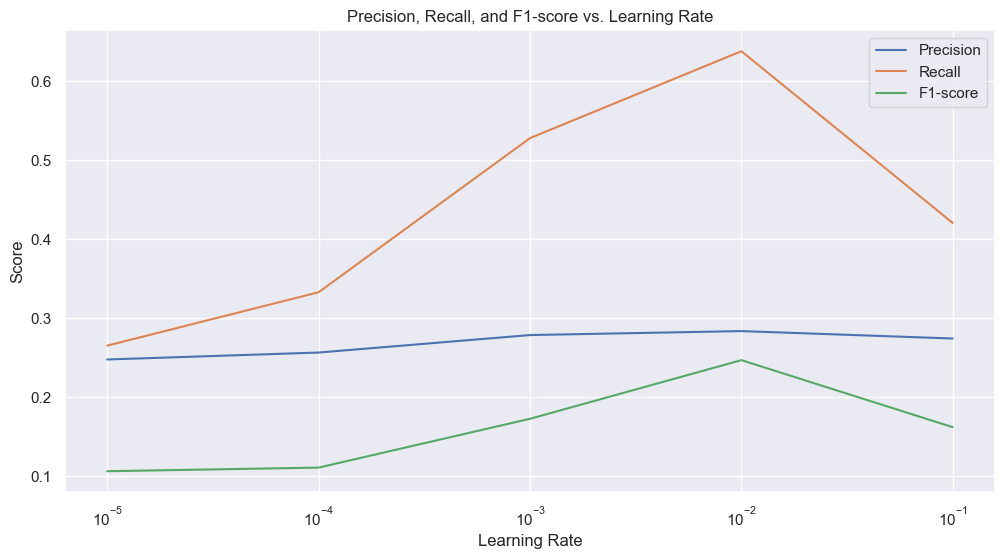

In [35]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
sns.set()

# Assuming you have already optimized the study and have obtained the mean cross-validation scores
# for precision, recall, and F1-score for each learning rate
learning_rates = [1e-1, 1e-2,1e-3, 1e-4, 1e-5]
# Extract the scores from the dictionaries in the order of the learning rates
precision_scores_plt = [mean_cv_precision_scores[lr] for lr in learning_rates]
recall_scores_plt = [mean_cv_recall_scores[lr] for lr in learning_rates]
f1_scores_plt = [mean_cv_f1_scores[lr] for lr in learning_rates]

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the precision scores
ax.plot(learning_rates, precision_scores_plt, label="Precision")

# Plot the recall scores
ax.plot(learning_rates, recall_scores_plt, label="Recall")

# Plot the F1 scores
ax.plot(learning_rates, f1_scores_plt, label="F1-score")

# Set the axis labels and title
ax.set_xlabel("Learning Rate")
ax.set_ylabel("Score")
ax.set_xscale("log")
ax.set_title("Precision, Recall, and F1-score vs. Learning Rate")

# Add a legend
ax.legend()

# Show the plot
plt.show()

In [34]:
# Get a DataFrame containing the results of all trials
df = study.trials_dataframe()

# Display the DataFrame
print(df)

   number     value             datetime_start          datetime_complete  \
0       0  0.162007 2023-05-20 13:26:17.199613 2023-05-20 13:31:44.539735   
1       1  0.246816 2023-05-20 13:31:44.599857 2023-05-20 13:36:51.638383   
2       2  0.172600 2023-05-20 13:36:51.689700 2023-05-20 13:41:59.327409   
3       3  0.110866 2023-05-20 13:41:59.379059 2023-05-20 13:47:25.274573   
4       4  0.106272 2023-05-20 13:47:25.337250 2023-05-20 13:53:24.171396   

                duration  params_learning_rate  system_attrs_grid_id  \
0 0 days 00:05:27.340122               0.10000                     4   
1 0 days 00:05:07.038526               0.01000                     3   
2 0 days 00:05:07.637709               0.00100                     2   
3 0 days 00:05:25.895514               0.00010                     1   
4 0 days 00:05:58.834146               0.00001                     0   

                           system_attrs_search_space     state  
0  {'learning_rate': [1e-05, 0.0001, 0.

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
fig = optuna.visualization.plot_slice(study)
fig

In [ ]:
best_model_path_dot = "./pytorch/best_dot_product_model.pt"

if os.path.exists(best_model_path_dot):
    best_reading_comp_dot = torch.load(best_model_path_dot)
    best_criterion_dot = nn.CrossEntropyLoss(
        weight=class_weights
    )  # to account for imbalanced class weights
else:
    best_reading_comp_dot, best_criterion_dot = train(
        attention_method="dot_product", learning_rate=trial.params["learning_rate"]
    )
    torch.save(best_reading_comp_dot, best_model_path_dot)

# Model evaluation
best_train_report, best_test_report = evaluate(
    best_reading_comp_dot, as_doc_train, as_qn_train, train_labels, best_criterion_dot
), evaluate(
    best_reading_comp_dot, as_doc_test, as_qn_test, test_labels, best_criterion_dot
)

Epoch 1/10, Loss: 1.3867
Epoch 2/10, Loss: 1.2868
Epoch 3/10, Loss: 1.1253
Epoch 4/10, Loss: 0.9606
Epoch 5/10, Loss: 0.8766
Epoch 6/10, Loss: 1.0260
Epoch 7/10, Loss: 0.8106
Epoch 8/10, Loss: 0.8692
Epoch 9/10, Loss: 0.7638
Epoch 10/10, Loss: 0.7118
